# **TP Wavelets**

In this TP, we will work on some fundamental concepts in Wavelets and compression of images.

First we'll briefly check the limitations of the Fourier transform. We'll then check some fundamental properties of a family of Wavelets and compute the Wavelet transform of a very simple signal. In the second part of the TP, we will use the DWT to compress and image.

Make sure to sequentially run all the cells in each section, so that the intermediate variables / packages will carry over to the next cell

We recommend you save a copy of this colab in your drive so you don't lose progress!

**Note 1:** As mentioned in the course and since there's not any policy regarding ChatGPT at Télécom level yet, you can use it. However, using ChatGPT without understanding their outputs is not OK, and will be penalized accordingly in your grade. Please be sure of all the functions you'll use.

**Note 2:** Several points have associated questions. When answering these questions, all responses should be properly justified. ChatGPT answers are very easy to spot.

**Note 3:** Always plot the functions and outputs you're generating. If the output or function is not properly plotted/shown, this will reduce points in your grade.

# Setup
First, we install PyWavelets

In [2]:
!pip install PyWavelets


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve
import requests

pywt.__version__

'1.7.0'

# Important
Google Colab is an interesting tool to try things out quickly. However, Google Colab and more general Notebooks are not meant to be an Integrated Development Environment (IDE). For a real job, please use an actual IDE like PyCharm or VS Code.

# Limitation of the Fourier Transform
*   Create a sinusoidal signal of 2.5 seconds of duration.
*   Set up a sampling rate of 20kHz. The signal should be divided in 5 parts of 0.5 seconds of duration each.
*  The signal should have the following frequencies in this order {10 Hz, 30 Hz, 60 Hz, 30 Hz, 10 Hz}.

In [4]:
# On va définir une fonction qui réalise l'opération demandée. Ainsi si on souhaite tester avec d'autres paramètres,
# on pourra le faire simplement.

def changing_sinus(Fe,T,f):
    n_pt = int(Fe*T)
    t = np.linspace(0,T,int(n_pt))
    X=np.zeros(n_pt)
    for i in range(len(f)):
        sinus = np.sin(2*np.pi*f[i]*t[i*int(Fe*T/len(f)):(i+1)*int(Fe*T/len(f))])
        X[i*int(Fe*T/len(f)):(i+1)*int(Fe*T/len(f))]=sinus
    return t,X

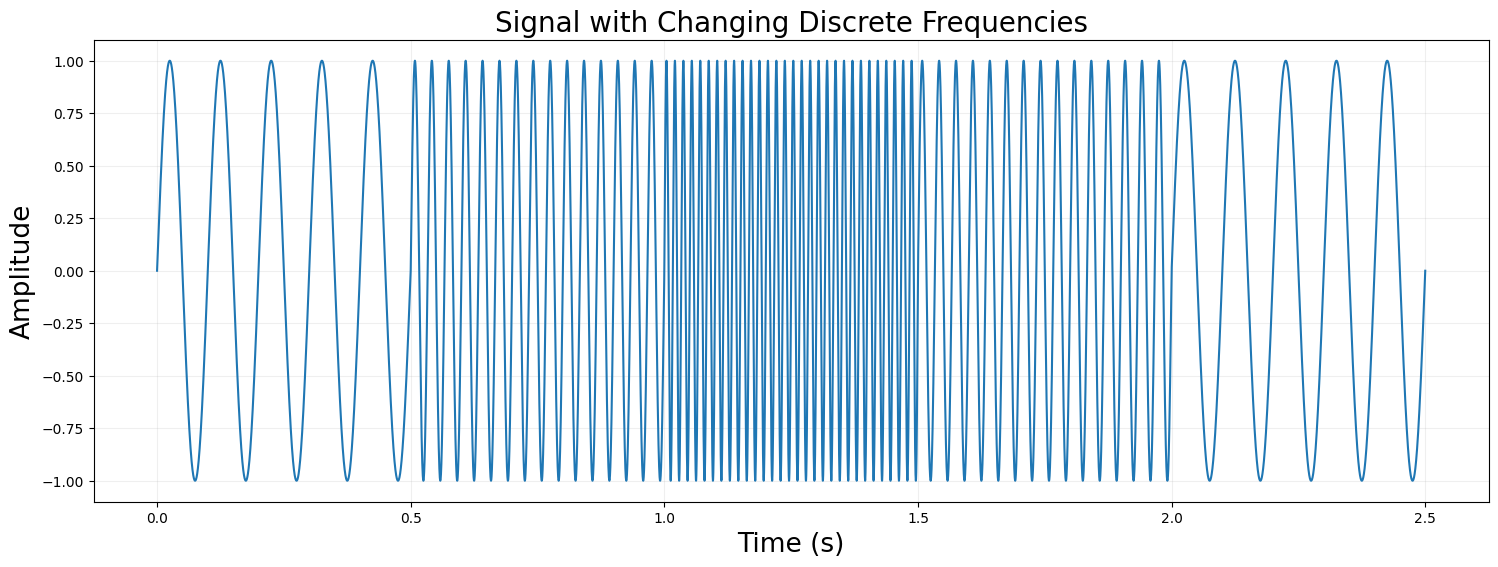

In [5]:
Fe=20000
T=2.5 # en secondes
f=[10,30,60,30,10]

time, signal = changing_sinus(Fe,T,f)

font_size = 20
plt.figure(figsize=(18, 6))
plt.plot(time, signal, linewidth=1.5)
plt.title('Signal with Changing Discrete Frequencies', fontsize=font_size)
plt.xlabel('Time (s)', fontsize=font_size-1)
plt.ylabel('Amplitude', fontsize=font_size-1)
plt.grid(alpha=0.2)

Now, you should compute the Discrete Fourier Transform of the signal. You can use any library from Python you prefer. You might need to cut the x-axis in the Fourier transform up to 100 Hz in the visualization. Please check https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html and https://numpy.org/doc/stable/reference/generated/numpy.fft.fftfreq.html

In [6]:
# Calcul de la DFT du signal
DFT = np.fft.fft(signal)
freq = np.fft.fftfreq(len(signal), 1/Fe)

# J'ai voulu tester en réalisant du zero-padding pour mieux observer les variations de cette DFT
add = np.zeros(19*len(signal))
signal_padding = np.concatenate((signal, add))
DFT_zeropadding = np.fft.fft(signal_padding)
freq_zeropadding = np.fft.fftfreq(len(signal_padding), 1/Fe)

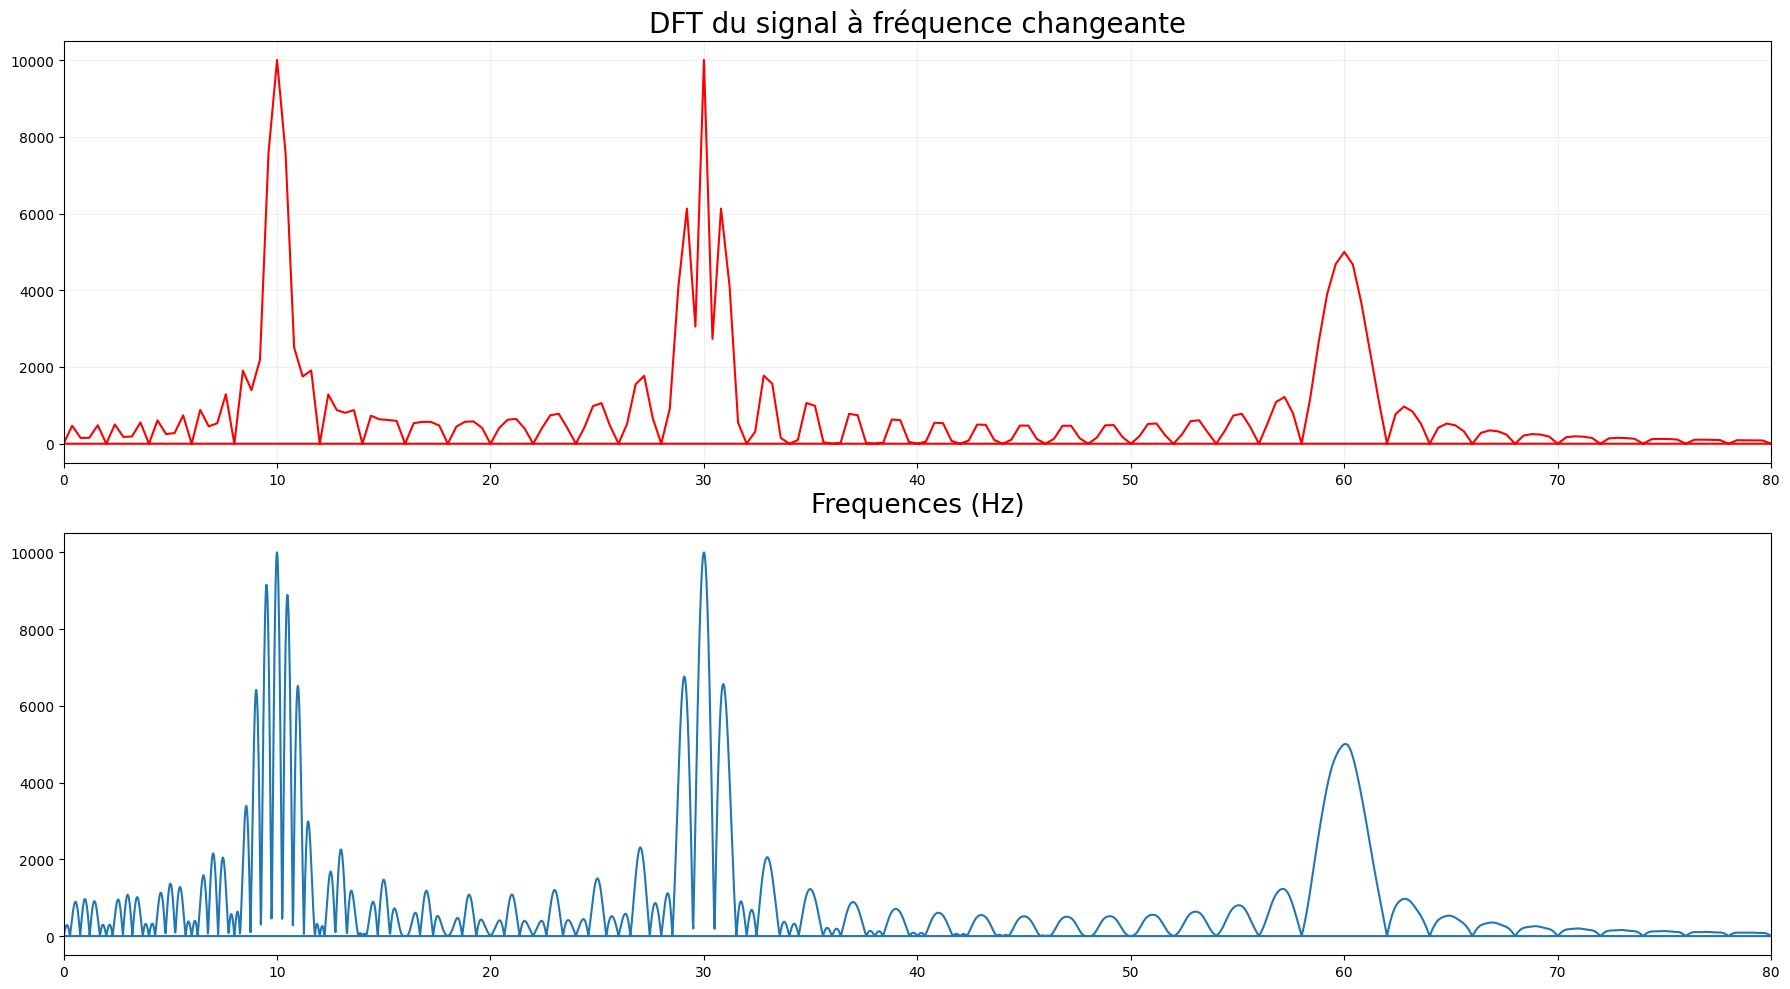

In [7]:
plt.figure(figsize=(18,10))
plt.subplot(211)
plt.plot(freq, np.abs(DFT), linewidth=1.5, color='red')
plt.title('DFT du signal à fréquence changeante', fontsize=font_size)
plt.xlabel('Frequences (Hz)', fontsize=font_size-1)
plt.xlim(0,80)
plt.grid(alpha=0.2)
plt.subplot(212)
plt.plot(freq_zeropadding, np.abs(DFT_zeropadding), linewidth=1.5)
plt.xlim(0,80)
plt.tight_layout()

**QUESTIONS**

1) Does the established sampling rate satisfy the Nyquist-Shannon sampling theorem to avoid aliasing? Please justify.

2) What can you say from the signal looking **only** at the Fourier transform?

3) Can you be certain about the location of some frequency component in the time domain? Why?

**YOUR ANSWERS HERE:**

1)

2)

3)

# **Mother Wavelet**
As we saw in the course, a wavelet is not just a function but a whole family of functions that satisfy certain requirements. In this part of the TP we're gonna work with the Morlet wavelet defined as follows: $\Psi(t)=k e^{iw_0t}e^{-\frac{1}{2}(\frac{t}{\sigma})^2}$. Please generate a Morlet wavelet in Python **WITHOUT using PyWavelets** with the following parameters:

-Center frequency of the wavelet = 10 Hz

-Sampling rate $\eta$ = 20000 Hz

-$k=\frac{1}{\sqrt{\eta}}$

-$\sigma = 0.1$

You can generate the wavelet between -1 and 1 seconds, so the time duration of the wavelet is 2 seconds. For this part, you just need to generate the real part of the wavelet.

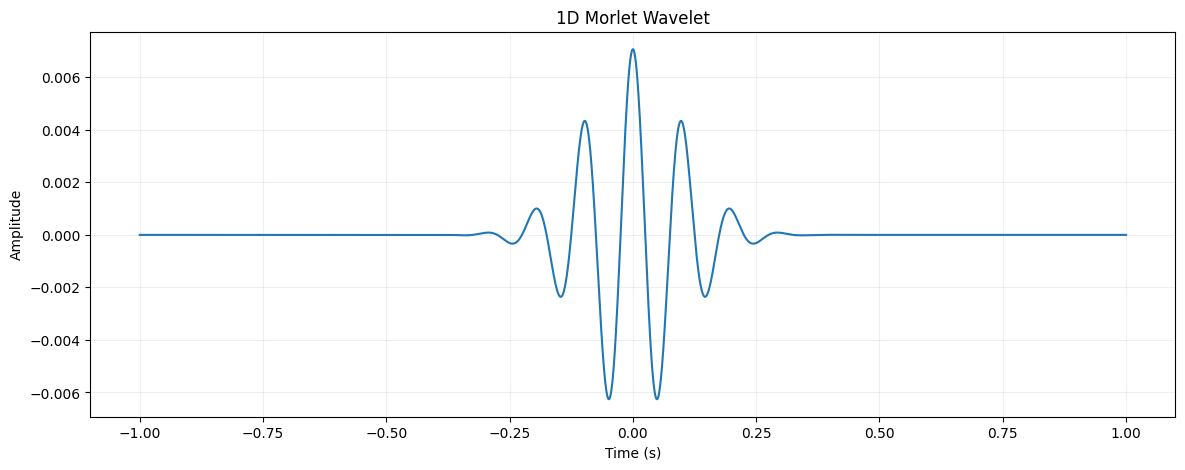

In [8]:
eta = 20000
freq_centrale = 10
w_0 = 2*np.pi*freq_centrale
sigma = 0.1
tps = np.linspace(-1, 1, eta*2)

def morlet_constructor(w_0,sigma,tps):
    morlet = (1/np.sqrt(eta))*np.cos(w_0*tps)*np.exp((-1/2)*(tps**2/sigma**2))
    return morlet

morlet = morlet_constructor(w_0,sigma,tps)

plt.figure(figsize=(14,5))

plt.plot(tps,morlet)
plt.title('1D Morlet Wavelet')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(alpha=0.2)

Please show that the mother wavelet we just created satisfies the admissibility and the finite energy conditions.

Pour vérifier cela, on doit :
- Vérifier que la fonction ainsi définie est de moyenne nulle (admissibility condition).
- Vérifier que l'énergie est finie. Cette partie est évidente puisque la fonction qu'on à définie est bornée sur $[-1,1]$ et continue sur cette intervalle. Elle est donc nécessairement d'énergie finie. Même si on l'étendait à $[-\infty,\infty]$, le terme en $\exp(-t^2)$ assure une décroissance en zéro des deux cotés, qui permet de conclure quant à la bonne définition de l'intégrale par croissance comparée.

In [9]:
# admissibility condition
moyenne = np.mean(morlet)
print('Moyenne :', moyenne)
# cette valeur est extrêmement proche de 0, on va donc l'accepter comme nulle.

# energie finie 
energie = np.sum(np.abs(morlet)**2)
print('Energie :', energie)
# la valeur étant finie, la condition d'énergie finie est vérifiée

Moyenne : 2.3708530469514508e-12
Energie : 0.08862047697796217


**Note:** In real life, you have to deal with finite-precision related problems. Therefore, if for the admissibility condition you don't have exactly the value you were expecting for, don't worry.

# **Convolution**

As we saw in the course, we need a measure of similarity to compute the wavelet transform. We also saw that we can easily compute the shift in time and similarity calculation with the 1-D convolutions.

* Generate a chirp sinusoidal signal from -5 to 5 seconds with an initial frequency of 5 Hz and final frequency of 15 Hz and sampling rate of 20kHz:

Text(0.5, 0, 'Time')

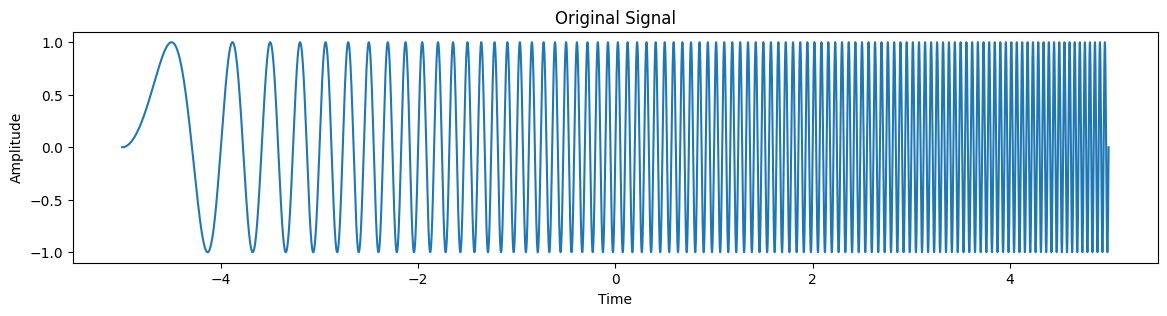

In [10]:
time_signal = np.linspace(-5,5,20000*10)
init_freq = 5
end_freq = 15

def chirp_constructor(time_signal,init_freq,end_freq):
    freqs = np.linspace(init_freq,end_freq,len(time_signal))
    chirp = np.sin(2*np.pi*freqs*time_signal)
    return chirp

chirp = chirp_constructor(time_signal,init_freq,end_freq)

plt.figure(figsize=(14,3))
plt.plot(time_signal, chirp)
plt.title('Original Signal')
plt.ylabel('Amplitude')
plt.xlabel('Time')

Now create a Morlet wavelet with the following parameters:

* Center frequency of the wavelet = 10 Hz

* Sampling rate $\eta$ = 20000 Hz

* $k=\frac{1}{\sqrt{\eta}}$
* $\sigma = 0.2$
* Duration = 2 seconds


Text(0.5, 0, 'Time')

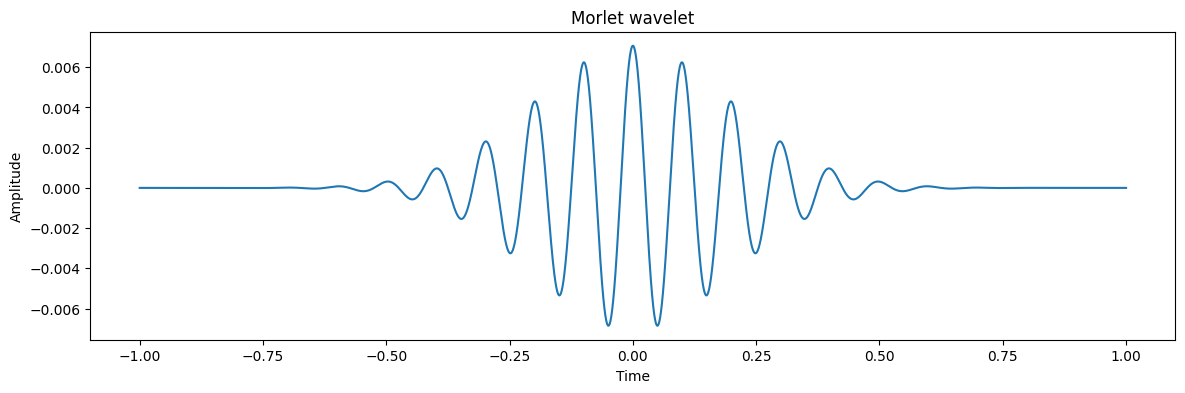

In [11]:
w_1 = 2*np.pi*10
sigma = 0.2
time_signal = np.linspace(-1,1,eta*2)

def morlet_complex_constructor(w_1,sigma,time_signal):
    morlet = (1/np.sqrt(eta))*np.exp(1j*w_1*time_signal)*np.exp((-1/2)*(time_signal**2/sigma**2))
    return morlet

morlet_wavelet = morlet_complex_constructor(w_1,sigma,time_signal)

plt.figure(figsize=(14,4))
plt.plot(time_signal, np.real(morlet_wavelet))
plt.title('Morlet wavelet')
plt.ylabel('Amplitude')
plt.xlabel('Time')

Compute the convolution between the signal and $Re(\Psi(t))$. For reference on how to perform convolution with scipy 'convolve' function, please check https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve.html

Text(0, 0.5, 'Amplitude')

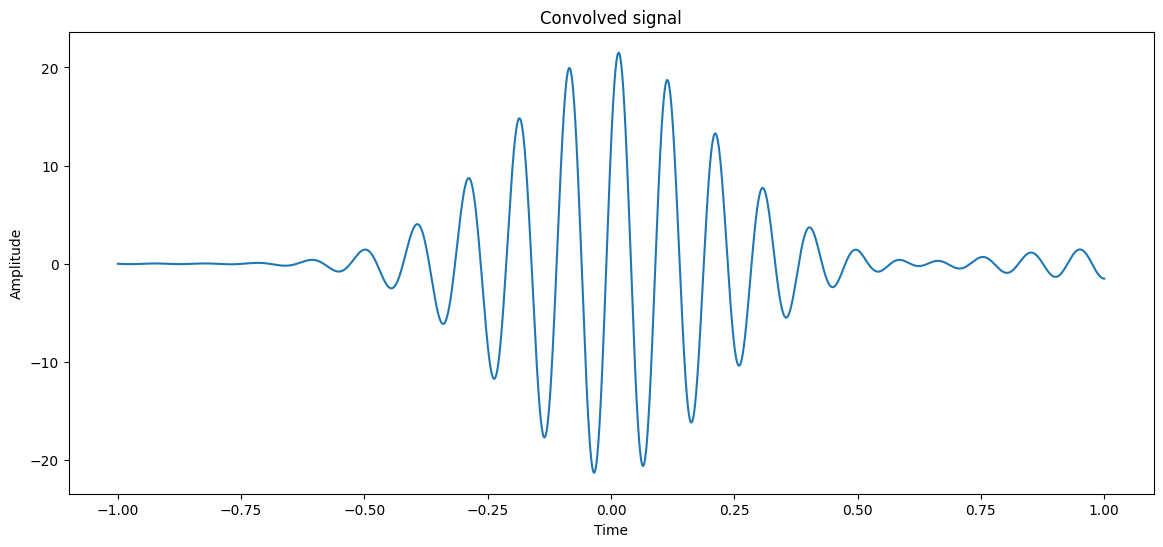

In [12]:
chirp = chirp_constructor(time_signal,init_freq,end_freq)
re_morlet = np.real(morlet_wavelet)

convolved_signal = convolve(chirp,re_morlet,mode="same",method="auto")

plt.figure(figsize=(14, 6))
plt.plot(time_signal,convolved_signal)
plt.title('Convolved signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')

There are some points where the convolution is zero, even in regions of high similarity between the wavelet and the signal. **Is this OK?** If it's not, propose a solution to that.

C'est du au fait qu'on ne prenne en compte dans notre calcul que la partie réelle de la wavelet de morlet. Pour avoir un meilleur résultat il nous faut la considérer "en entier". Tentons d'implémenter ceci.

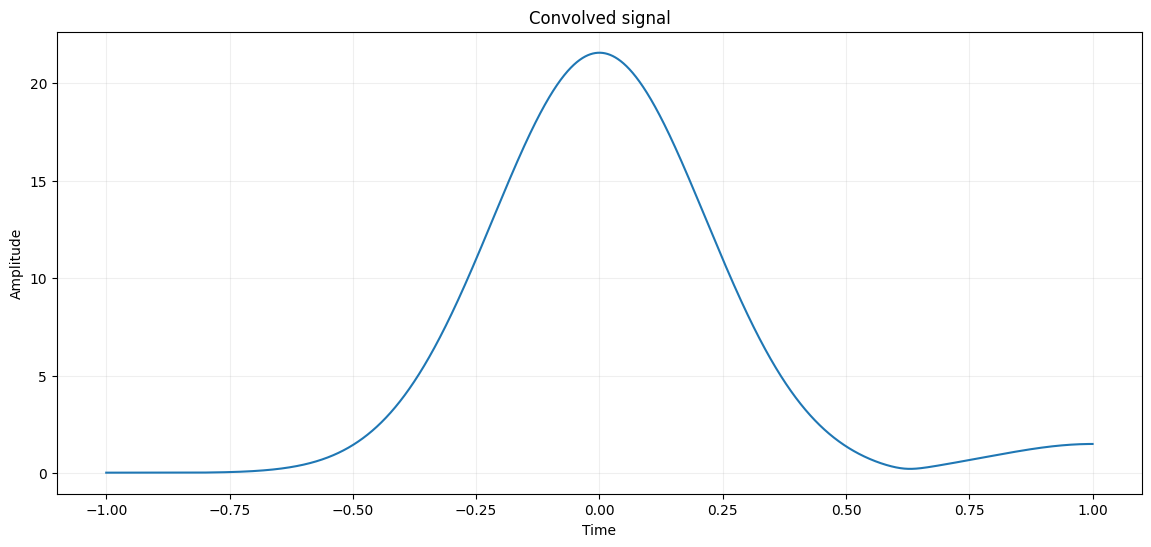

In [13]:
# on re définit notre wavelet et notre signal pour éviter tout conflit
morlet = morlet_complex_constructor(w_1,sigma,time_signal)
chirp = chirp_constructor(time_signal,init_freq,end_freq)
# on sépare la wavelet en partie réelle et partie imaginaire
re_morlet = np.real(morlet)
im_morlet = np.imag(morlet)

# effectuons la convolution de chaque partie
convolved_signal_re = convolve(chirp,re_morlet,mode="same",method="auto")
convolved_signal_im = convolve(chirp,im_morlet,mode="same",method="auto")
# pour obtenir quelque chose de "tracable", on calcule le module
convolved = np.sqrt(convolved_signal_re**2+convolved_signal_im**2)

plt.figure(figsize=(14, 6))
plt.plot(time_signal,convolved)
plt.title('Convolved signal')
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.grid(alpha=0.2)

# **Image Compression**
For this part, we'll use the Discrete Wavelet Transform (DWT) implemented as a filter bank to do image compression. The first step is to have an image to compress. For doing so you can use the following piece of code to download an image of Trudy.

In [14]:
url = "https://raw.githubusercontent.com/jhonygiraldo/jhonygiraldo.github.io/main/Trudy_for_compression.jpeg"
response = requests.get(url)

with open('Trudy_for_compression.jpeg', 'wb') as f:
    f.write(response.content)

**Visualize image:** With the following code you can visualize the image. If you're using Google Collab, most probably you already have the open cv library installed. If you're using Jupyter Notebook for example, you'll have to install open cv if it's not already installed.

In [15]:
# Let us define a function for visualizing images
def show_image(image, title='Input Image', font_size=12,fig_size = (10, 10)):
  #A function that uses matplotlib to show grayscale images
  plt.figure(figsize=fig_size)
  plt.imshow(image, cmap='gray')
  plt.title(title, fontsize=font_size)
  plt.axis('off')

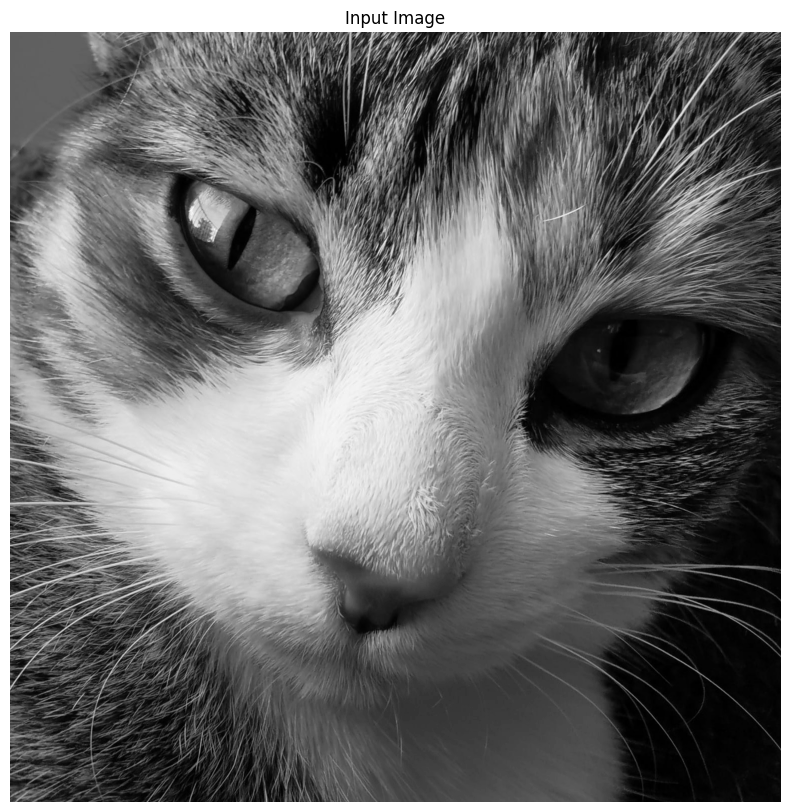

In [16]:
import cv2

# Load your image as a grayscale
input_image = cv2.imread('Trudy_for_compression.jpeg', cv2.IMREAD_GRAYSCALE)
show_image(input_image, 'Input Image')

If you use some wavelet function (Biorthogonal 1.3 in this case), the 1-level 2D wavelet decomposition of our input image is given as follows:

In [17]:
# # You can see a list of wavelet families
import pywt
pywt.families()

['haar',
 'db',
 'sym',
 'coif',
 'bior',
 'rbio',
 'dmey',
 'gaus',
 'mexh',
 'morl',
 'cgau',
 'shan',
 'fbsp',
 'cmor']

In [18]:
# For each family, you can list the available wavelets
pywt.wavelist(family='db', kind='all')

['db1',
 'db2',
 'db3',
 'db4',
 'db5',
 'db6',
 'db7',
 'db8',
 'db9',
 'db10',
 'db11',
 'db12',
 'db13',
 'db14',
 'db15',
 'db16',
 'db17',
 'db18',
 'db19',
 'db20',
 'db21',
 'db22',
 'db23',
 'db24',
 'db25',
 'db26',
 'db27',
 'db28',
 'db29',
 'db30',
 'db31',
 'db32',
 'db33',
 'db34',
 'db35',
 'db36',
 'db37',
 'db38']

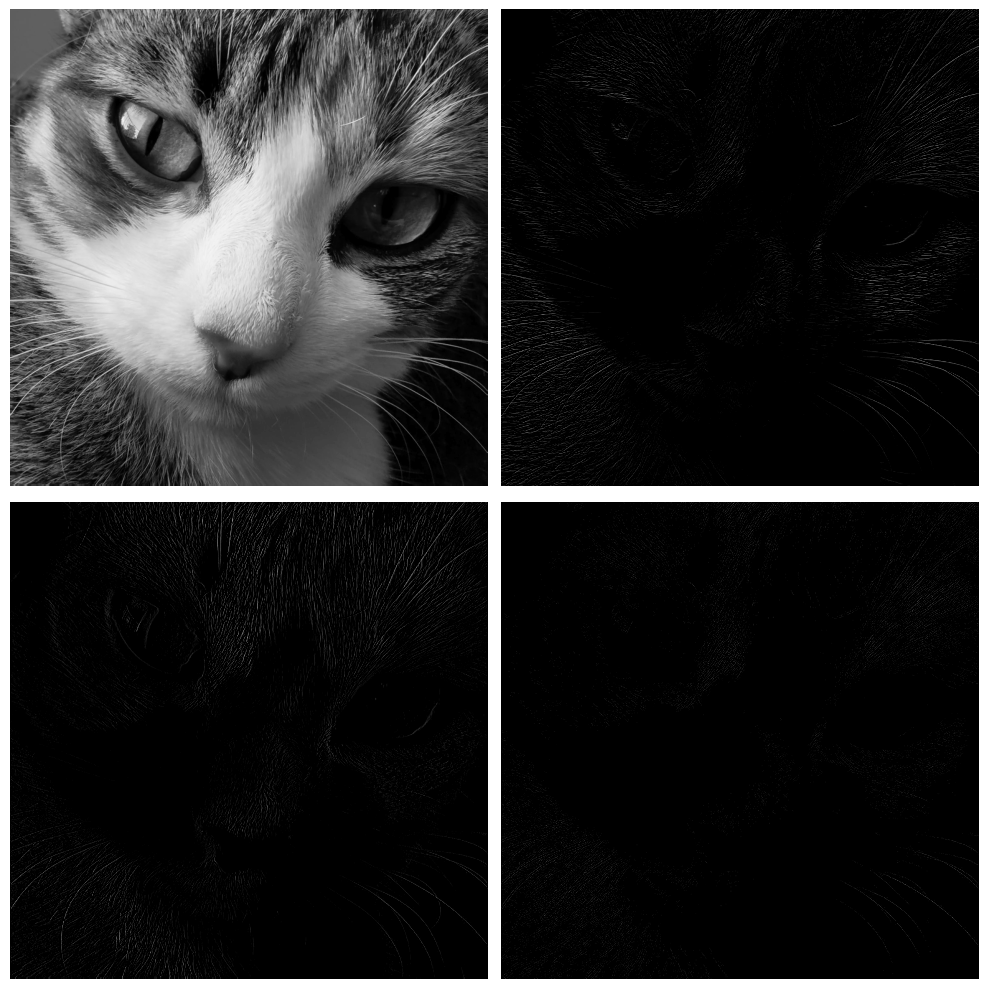

In [19]:
coeffs = pywt.dwt2(input_image, 'bior1.3')
LL,(LH,HL,HH) = coeffs

threshold = 0.01*np.max([LL,LH,HL,HH])
LL_thresh = np.where(np.abs(LL)>threshold,LL,0)
LH_thresh = np.where(np.abs(LH)>threshold,LH,0)
HL_thresh = np.where(np.abs(HL)>threshold,HL,0)
HH_thresh = np.where(np.abs(HH)>threshold,HH,0)

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(LL_thresh, cmap='gray', vmin=0, vmax=np.max(LL_thresh))
plt.axis('off')

plt.subplot(222)
plt.imshow(LH_thresh, cmap='gray', vmin=0, vmax=np.max(LH_thresh))
plt.axis('off')

plt.subplot(223)
plt.imshow(HL_thresh, cmap='gray', vmin=0, vmax=np.max(HL_thresh))
plt.axis('off')

plt.subplot(224)
plt.imshow(HH_thresh, cmap='gray', vmin=0, vmax=np.max(HH_thresh))
plt.axis('off')
plt.tight_layout()
plt.show()


In the previous image we applied a threshold in the wavelet coefficients for visualization purposes. **Please explain the meaning of each of these 4 images**.

**ANSWER :**
Les 4 images ci dessus représentent chacune :
- Haut-Gauche : C'est l'image d'origine avec un niveau de détail en moins. On pourrait la traduire par l'image d'origine à laquelle on a enlevé les détails présents dans les 3 autres images
- Haut-Droite : C'est l'image qui conserve les composantes hautes fréquences selon l'axe vertical (c'est à dire les bords). Si on trace sur notre image un trait horizontal par exemple, il apparaitra sur cette image.
- Bas-Gauche : C'est de manière similaire celle qui conserve les détails horizontaux. Si on trace sur notre image un trait vertical par exemple, il apparaitra sur cette image.
- Bas-Droite : Complémentaire aux deux précédentes, elle se charge des détails diagonaux.


Now, you should compute the six-levels 2D wavelet decomposition of the input image with a Daubechies wavelet with six vanishing moments using the PyWavelet library. Please check https://pywavelets.readthedocs.io/en/latest/ref/2d-dwt-and-idwt.html#d-multilevel-decomposition-using-wavedec2

In [ ]:
coeffs_6 = pywt.wavedec2(input_image, 'db1', level=6)
print(len(coeffs_6))

coeffs_6_thresh = [np.where(np.abs(coeff)>0.01*np.max(coeff),coeff,0) for coeff in coeffs_6]



7


* Set a threshold of value of 100 and take to zero the values less than that in the 2D wavelet decomposition. **Note:** You should only threshold the outputs of the high-pass filters.



In [21]:
# Your code here
...

* Compute the IDWT to reconstruct the image after the "compression". Check https://pywavelets.readthedocs.io/en/latest/ref/2d-dwt-and-idwt.html#d-multilevel-reconstruction-using-waverec2 as a reference.

In [22]:
# Your code here
...

#plot compressed image
show_image(compressed_image, 'Compressed Image')

NameError: name 'compressed_image' is not defined

What's the compression ratio?

In [ ]:
# Your code here
...

# **Putting everything together**

In this exercise we'll analyze the Peak Signal to Noise Ration (PSNR) of the compressed images for different thresholds. For doing so, we'll give you the function to compute the PSNR between the original and compressed image.

In [ ]:
def psnr(original_image, compressed_image):
    h,w = original_image.shape
    mse = np.sum(np.abs(original_image-compressed_image)**2)/(h*w)
    return 20* np.log10(255**2/mse)

Now, you have to create a function codec that receives the input image, the wavelet to be used, the number of levels, and the threshold value. This function returns the compressed image and the compression ratio. **Note:** You already did that previously.

In [ ]:
def codec(input_image,wavelet='db4',num_levels=6,threshold=100):
  # Your code here
  ...
  return ...

Now, we compare the performance of the 'db4' and the 'bior1.3' wavelets in terms of compression ratio and PSNR for different thresholds.

In [ ]:
wavelet_1 = 'db4'
wavelet_2 = 'bior1.3'
thresholds = [5,10,20,40,80,100]
num_levels=6

# Your code here
...

**QUESTIONS**

1) Which wavelet is better for the Trudy_for_compression.jpeg image and why?

# Supplementary Exercises (Optional)
1. Designing and using custom filters with the pyWavelets library
Reference (https://pywavelets.readthedocs.io/en/latest/ref/wavelets.html#wavelet-families)
2. Propose and explore custom wavelets that achieve equivalent or higher compression ratio on the Trudy image explored previously. **P.S** You are free to explore any approach here.